In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
female = torchvision.datasets.ImageFolder('/content/drive/My Drive/faces94/female', transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]))
male = torchvision.datasets.ImageFolder('/content/drive/My Drive/faces94/male', transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]))
malestaff = torchvision.datasets.ImageFolder('/content/drive/My Drive/faces94/malestaff', transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]))

In [ ]:
Dataloader = [torch.utils.data.DataLoader(female, batch_size=128, shuffle=True, num_workers=4), 
              torch.utils.data.DataLoader(male, batch_size=128, shuffle=True, num_workers=4), 
              torch.utils.data.DataLoader(malestaff, batch_size=128, shuffle=True, num_workers=4)] 

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

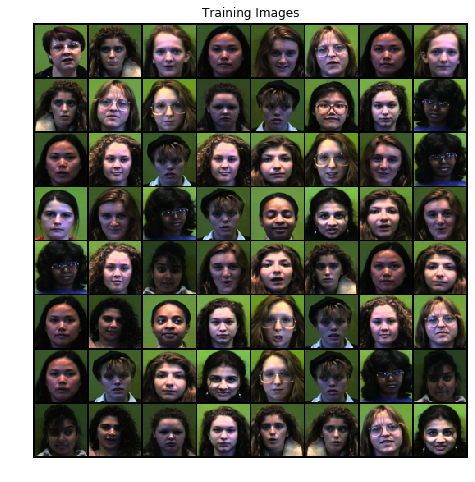

In [ ]:
real_batch = next(iter(Dataloader[0]))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.encoder = torch.nn.Sequential(
                                       torch.nn.Conv2d(3, 64, 4, 2, 1, bias = False),
                                       torch.nn.LeakyReLU(0.2, inplace=True),
                                       torch.nn.Conv2d(64, 128, 4, 2, 1, bias = False),
                                       torch.nn.BatchNorm2d(128),
                                       torch.nn.LeakyReLU(0.2, inplace=True),
                                       torch.nn.Conv2d(128, 256, 4, 2, 1, bias = False),
                                       torch.nn.BatchNorm2d(256),
                                       torch.nn.LeakyReLU(0.2, inplace=True),
                                       torch.nn.Conv2d(256, 512, 4, 2, 1, bias = False),
                                       torch.nn.BatchNorm2d(512),
                                       torch.nn.LeakyReLU(0.2, inplace=True),
                                       torch.nn.Conv2d(512, 100, 4, 1, 0, bias = False),
                                      )
  def forward(self, inp):
    return self.encoder(inp)
class Decoder(torch.nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.decoder = torch.nn.Sequential(
                                   torch.nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
                                   torch.nn.BatchNorm2d(512),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
                                   torch.nn.BatchNorm2d(256),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                                   torch.nn.BatchNorm2d(128),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                                   torch.nn.BatchNorm2d(64),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
                                   torch.nn.Tanh()
                                   )
  def forward(self, inp):
    return (self.decoder(inp))
class AutoEncoder(torch.nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
  def forward(self, inp):
    return self.decoder(self.encoder(inp))

In [ ]:
model = AutoEncoder()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
iterations = 0
model.to(device)
for epoch in range(150):
  for j in range(len(Dataloader)):
    total_loss = 0
    for i, data in enumerate(Dataloader[j], 0):
      optimizer.zero_grad()
      batch = data[0].to(device)
      batch_size = batch.size(0)
      gained_image = model(batch)
      gained_loss=loss(gained_image, batch)
      total_loss += gained_loss.mean().item()
      gained_loss.backward()
      optimizer.step()
  #exp_lr_scheduler.step()
  print("EPOCH:", epoch+1)
  print("AVERAGE LOSS:", total_loss)

EPOCH: 1
AVERAGE LOSS: 0.5863118320703506
EPOCH: 2
AVERAGE LOSS: 0.38147085905075073
EPOCH: 3
AVERAGE LOSS: 0.2990954965353012
EPOCH: 4
AVERAGE LOSS: 0.26275499165058136
EPOCH: 5
AVERAGE LOSS: 0.2311062552034855
EPOCH: 6
AVERAGE LOSS: 0.20309282839298248
EPOCH: 7
AVERAGE LOSS: 0.18665751442313194
EPOCH: 8
AVERAGE LOSS: 0.17240512743592262
EPOCH: 9
AVERAGE LOSS: 0.15690069645643234
EPOCH: 10
AVERAGE LOSS: 0.1429864466190338
EPOCH: 11
AVERAGE LOSS: 0.13616230338811874
EPOCH: 12
AVERAGE LOSS: 0.14070179127156734
EPOCH: 13
AVERAGE LOSS: 0.1248478889465332
EPOCH: 14
AVERAGE LOSS: 0.11814807914197445
EPOCH: 15
AVERAGE LOSS: 0.10559659078717232
EPOCH: 16
AVERAGE LOSS: 0.10561618767678738
EPOCH: 17
AVERAGE LOSS: 0.09791931882500648
EPOCH: 18
AVERAGE LOSS: 0.08591853454709053
EPOCH: 19
AVERAGE LOSS: 0.08536066114902496
EPOCH: 20
AVERAGE LOSS: 0.08406559564173222
EPOCH: 21
AVERAGE LOSS: 0.081131836399436
EPOCH: 22
AVERAGE LOSS: 0.08646645210683346
EPOCH: 23
AVERAGE LOSS: 0.07949751615524292
EPOC

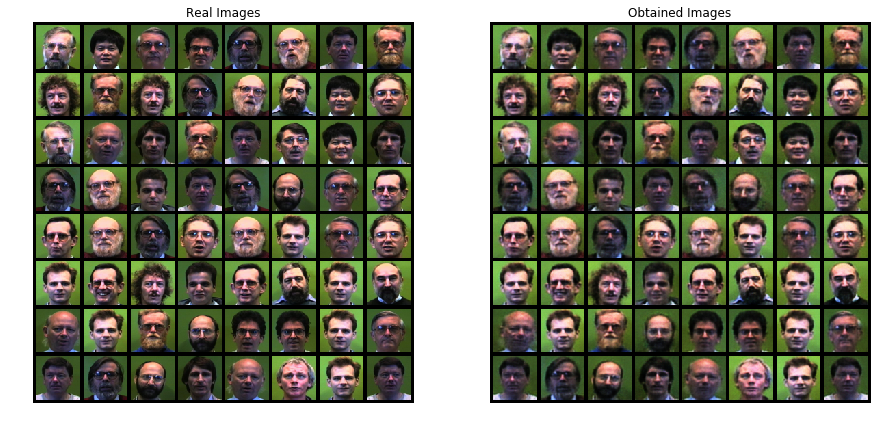

In [ ]:
with torch.no_grad():
  real_batch = next(iter(Dataloader[2]))
  plt.figure(figsize=(15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Obtained Images")
  plt.imshow(np.transpose(torchvision.utils.make_grid(model(real_batch[0].to(device)[:64]), padding=5, normalize=True).cpu(),(1,2,0)))
  plt.show()
  

In [ ]:
with torch.no_grad():
  latent_representations = np.array([model.encoder(next(iter(Dataloader[0]))[0].to(device))[0].cpu().numpy().transpose(1, 2, 0)[0][0],
   model.encoder(next(iter(Dataloader[1]))[0].to(device))[0].cpu().numpy().transpose(1, 2, 0)[0][0],
   model.encoder(next(iter(Dataloader[2]))[0].to(device))[0].cpu().numpy().transpose(1, 2, 0)[0][0]])

In [ ]:
np.savetxt("weights.csv", latent_representations, delimiter=",")